<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AtariスペースインベーダのPPO による強化学習の実装

参考

- https://github.com/vpj/rl_samples
http://blog.varunajayasiri.com/ml/ppo_pytorch.html

ほぼそのままです。違いはクラウドログサービスを WandB に変更してあることと、そのままだと過学習のせいか得点が伸びずに戦略が固まってしまうようなので、εグリーディを pytorch だよりとは別に設定できるようにした点ぐらいです。

#### 他に参考にしたサイト

- [PythonでPPOを実装してみた](https://qiita.com/oki_uta_aiota/items/a15ba5de6ed3c1268ed3#%E5%85%A8%E4%BD%93%E3%81%AE%E3%82%B3%E3%83%BC%E3%83%89)

In [2]:
import random
import time
random.seed(time.time())

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

device(type='cpu')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 外部ライブラリの追加

In [4]:
!pip install pfrl > /dev/null
!pip install wandb > /dev/null
!pip install fastprogress > /dev/null
#!pip install gym[atari] > /dev/null

In [5]:
import multiprocessing
import multiprocessing.connection
from typing import Dict, List
from fastprogress.fastprogress import master_bar, progress_bar

import gym
from gym import ObservationWrapper
from gym.spaces import Box

import cv2
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.distributions import Categorical
from torch.nn import functional as F

from pfrl.wrappers.atari_wrappers import FrameStack,NoopResetEnv,MaxAndSkipEnv
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

import shutil

# ラッパー定義

In [6]:
class myCrop(ObservationWrapper):
    def __init__(self, env, tmgn=0, bmgn=0,lmgn=0,rmgn=0,igcolors=[],bgcolor=[0,0,0]):
        super(myCrop, self).__init__(env)
        self.tmgn, self.bmgn = tmgn, bmgn
        self.lmgn, self.rmgn = lmgn, rmgn
        self.igcolors, self.bgcolors = igcolors, bgcolor
        self.observation_space = Box(low=0, high=255, shape=(84,84), dtype=np.uint8)
    def observation(self, obs):
        img_mask = np.zeros(obs.shape[:2],np.uint8)
        for color in self.igcolors:
            bgrLower = np.array(color)    
            bgrUpper = np.array(color)
            tmask = cv2.inRange(obs, bgrLower, bgrUpper) 
            img_mask = cv2.bitwise_or(img_mask,tmask)
        obs = cv2.bitwise_and(obs,obs,mask=255-img_mask) # 元画像とマスクを合成
        RIGHT=obs.shape[1]-self.rmgn
        BOTTOM=obs.shape[0]-self.bmgn
        obs = obs[self.tmgn:BOTTOM,self.lmgn:RIGHT]
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        observation = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
        return observation

class myFrameStack(FrameStack):
    def __init__(self, env, k=8, mode=0,demo=False):
        super(myFrameStack, self).__init__(env, k=k, channel_order="chw")
        self.lives = 0
        self.lsumrewards = 0
        self.localsteps = 0
        self.demo = demo
        self.mode = mode
    def reset(self):
        ob = self.env.reset()
        return self._reset(ob)
    def _reset(self,ob):
        for _ in range(self.k):
          self.frames.append(ob)
        self.lives = self.env.unwrapped.ale.lives()
        self.lsumrewards = 0
        self.localsteps = 0
        return  np.array([list(self.frames)])
    def step(self, action):
        self.localsteps += 1  
        ob, reward, done1, info = self.env.step(action)
        self.lsumrewards += reward
        self.frames.append(ob)
        returnobs = np.array([list(self.frames)])
        episode_info = None
        if self.demo:
            return returnobs,rewad,done1,info
        # 残機数確認
        else: # if train mode
            lives = self.env.unwrapped.ale.lives()
            if done1 or lives < self.lives: # １機死んだら終了とする
                done = True
                episode_info = {"reward": self.lsumrewards, "length": self.localsteps}
                if done1 or self.mode == 0: 
                  self.reset() 
                else: # mode 1 ライフが減っただけの場合はシーンは継続
                  self._reset(ob)
            else:
                done = False
            return returnobs, reward, done, episode_info

def mkenv(envname,k=8,skip=2,tmgn=0,bmgn=0,lmgn=0,rmgn=0,igcolors=[],noop_max=30, mode = 0, demo=False):
  env=gym.make(envname)
  if noop_max > 0:
      env = NoopResetEnv(env, noop_max=noop_max)
  if skip > 1:
      env = MaxAndSkipEnv(env, skip=skip)
  env=myCrop(env, tmgn=tmgn, bmgn=bmgn, lmgn=lmgn, rmgn=rmgn, igcolors=igcolors)
  env=myFrameStack(env,k=k,mode=mode,demo=demo)
  return env

# Game Environment の定義

In [7]:
import random
from datetime import datetime
random.seed(datetime.now())
DEFAULTSEED = random.randint(1, 10000)
def Game(seed=DEFAULTSEED,k=8,skip=2,noop_max=30, mode = 0):
    ENV_NAME = 'SpaceInvadersNoFrameskip-v4'
    Tmgn=20
    Bmgn=12
    Lmgn=8
    Rmgn=8
    #NOCOLOR=[[162,134,56]]  # 背景と同一視するカラー
    NOCOLOR=[]

    env = mkenv(ENV_NAME,k,skip,Tmgn,Bmgn,Lmgn,Rmgn,NOCOLOR,noop_max=noop_max, mode = mode)
    env.seed(seed)
    return env

### 補足
**k** : 過去何フレーム分の画面をデータとするか  
**skip** : 何フレームおきにサンプリングするか  
**Tmgn,Bmgn,Lmgn,Rmgn** カットする余白量  
**NOCOLOR** 黒に置き換える色をRGB指定。複数指定可能  
上の設定はインベーダ決め打ち

## 動作確認

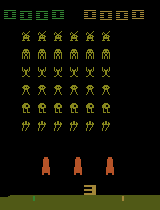

(210, 160, 3)

(7, 84, 84)

0

94

numpy.uint8

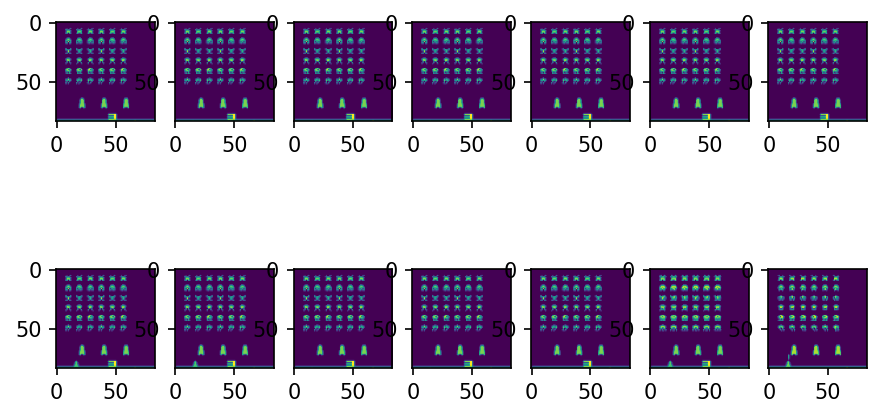

In [8]:
import random
from datetime import datetime
DEFAULTSEED = random.seed(datetime.now())

# 原画像が表示できるかテスト
game = Game(DEFAULTSEED,7)
orgimg = game.render(mode='rgb_array')
display(Image.fromarray(orgimg))
display(orgimg.shape)

# リセット画像の確認
plt.figure(figsize=(8,4),dpi=150)
imgs = game.reset()
imgs = imgs[0]
for i,img in enumerate(imgs):
    plt.subplot(2,8,i+1)
    plt.imshow(img)
# ステップ画像の確認
for _ in range(60):
  imgs,r,d,i= game.step(game.action_space.sample()) 
imgs = imgs[0]
for i,img in enumerate(imgs):
    plt.subplot(2,8,i+9)
    plt.imshow(img)
    
# Check types
display(imgs.shape,imgs[0,0,0],imgs[0,40,40],type(imgs[0,0,0]))

# PPO用ニューラルネットのモデル定義

In [9]:
class Model(nn.Module):

    def __init__(self,nframes=8):
        super().__init__()

        # 4x84x84 → 32x20x20 
        self.conv1 = nn.Conv2d(in_channels=nframes, out_channels=64, kernel_size=8, stride=4)
        # 32x20x20 →64x9x9
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2)
        # 64x9x9 → 64x7x7 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # 64x7x7 → FL 
        FL = 64
        self.lin = nn.Linear(in_features=7 * 7 * 64, out_features=FL)
        # FL → 4 actions 0-1 （行動決定）
        self.pi_logits = nn.Linear(in_features=FL, out_features=4)
        # 行動価値
        self.value = nn.Linear(in_features=FL, out_features=1)

    def forward(self, obs: torch.Tensor):
        h = F.relu(self.conv1(obs))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = h.reshape((-1, 7 * 7 * 64))

        h = F.relu(self.lin(h))

        pi = Categorical(logits=self.pi_logits(h))
        value = self.value(h).reshape(-1)

        return pi, value

# 動作確認

In [10]:
model = Model(16)
model.to(device)
game = Game(0,16)
obs = game.reset()
a=0
for i in range(200):
  obs,r,_,_ = game.step(a)
  pi,v = model.forward(torch.tensor(obs,dtype=torch.float32,device=device)/255)
for i in range(10):
  obs,r,_,_ = game.step(a)
  pi,v = model.forward(torch.tensor(obs,dtype=torch.float32,device=device)/255)
  a0 = pi.sample() # 方策関数によりアクションを決定
  a = a0[0] # アクション番号の数値化
  print(a)

display(obs.shape) # 画面データのシェイプを表示
display(a0)
display(a) # 選ばれたアクション番号を表示
print("初期は確率がほぼ等確率になっていることを確認")
for i in range(4):
    print(i,pow(np.e,(pi.log_prob(torch.tensor(i,device=device))))) # 
display(v.detach()) # 状態価値を表示
display(model) # モデルを表示

tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(3)
tensor(0)
tensor(1)
tensor(2)


(1, 16, 84, 84)

tensor([2])

tensor(2)

初期は確率がほぼ等確率になっていることを確認
0 tensor([0.2328], grad_fn=<PowBackward1>)
1 tensor([0.2407], grad_fn=<PowBackward1>)
2 tensor([0.2927], grad_fn=<PowBackward1>)
3 tensor([0.2338], grad_fn=<PowBackward1>)


tensor([0.0334])

Model(
  (conv1): Conv2d(16, 64, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (lin): Linear(in_features=3136, out_features=64, bias=True)
  (pi_logits): Linear(in_features=64, out_features=4, bias=True)
  (value): Linear(in_features=64, out_features=1, bias=True)
)

# Multiprocessing Playloop
# 学習のメインプログラム
### 並列ゲームプレイヤのクラス定義

In [11]:
def playloop(agent: multiprocessing.connection.Connection,seed:int,k=8,skip=2,noop_max=30, mode = 0):

    # create game
    game = Game(seed=seed, k=k,skip=skip,noop_max=noop_max, mode = mode)
    # AI player 
    while True:
        cmd, action = agent.recv()
        if cmd == "step":
            agent.send(game.step(action))
        elif cmd == "reset":
            agent.send(game.reset())
        elif cmd == "close":
            agent.close()
            break
        else:
            raise NotImplementedError

class CoPlayer:
    def __init__(self, seed, k=8,skip=2,noop_max=30,mode = 0):
        self.child, parent = multiprocessing.Pipe()
        self.process = multiprocessing.Process(target=playloop, args=(parent, seed, k,skip,noop_max,mode))
        self.process.start()

### パイプ動作確認

In [12]:
cop2 = CoPlayer(0,8)
cop2.child.send(("reset",None))
a = cop2.child.recv()
cop2.child.send(("step",1))
a2,b,c,d = cop2.child.recv()
cop2.child.send(("close",None))
a.shape,a2.shape,b,c,d

((1, 8, 84, 84), (1, 8, 84, 84), 0.0, False, None)

### ログフォルダの設定

In [13]:
import os
SAVEFOLDER = '/content/drive/MyDrive/M/ppo'
os.makedirs(SAVEFOLDER,exist_ok=True)
modelPath = SAVEFOLDER+"/model"  # モデルの重みファイル名  (拡張子　.pt　が自動的に補われる）

#### ハイパーパラメータの（一部）
ハイパーパラメータのうち、ネットワークに関するものは上に、一部は Main のパラメータに、一部は関数定義に埋め込み

In [14]:
NCYCLES = 2000 # 学習サイクル数　（データ収集→学習　が1サイクル）

END_GREEDY_Progress = 0.0 # 0.8  付加的な擾乱期間　開始から全体の 0.8
GreedyEPS_START = 0.0 # 0.3 擾乱期間開始時の付加的擾乱
GreedyEPS_END = 0.0 # 0.1 擾乱期間終了後の付加的擾乱

END_LOSTLIFE_Penalty_Progress = 1.0 # 1.0  初期の仮ペナルティ適用期間　開始から終了までの期間に対する割合

# Hyper Parameters
GAMMA = 0.93 # 0.99
LAMDA = 0.90 # 0.906
EPOCHS =  4 # サンプル１セットを何度学習プロセスに通すか
NPLAYERS = 8 # 並列実行する数game
NBATCHES = 256 # １度に処理するデータ数
NDIVIDE = 4 # バッチの分割数
SEEDZero = random.randint(1,10000)
LearningRate = 0.0015
NFRAMES = 6
W_VFLOSS = 0.6 # loss におけるvfloss の重み
W_BONUS = 0.01 # loss における entropy bonus の重み　0.088
CLIPRANGE = 0.2 # ## Run it

In [16]:
class Main:
    # mode 0 ：ライフが失われたらリセット、 mode 1：ライフが残っている場合は、画面を継続
    def __init__(self,seed=SEEDZero,k=NFRAMES,skip=2,deadloss=38,noop_max=16,resume=False,ncycles=NCYCLES,mode = 0, lr=LearningRate,gamma=GAMMA,lamda=LAMDA,eb = W_BONUS):

        self.lr = lr
        self.gamma = gamma
        self.lamda = lamda
        self.eb = eb
        self.k = k
        self.ncycles = ncycles

        self.lifes = 0 # 失った機体数 lost lifes
        self.cycles = 0 # バッチ回数
        self.deadloss = deadloss
        self.mode = mode

        self.progress = 0
        
        # 1サイクルに必要なサンプル数
        self.batch_size = NPLAYERS * NBATCHES
        # ミニバッチのサイズ
        self.mini_batch_size = self.batch_size // NDIVIDE

        # 初期化  
        # CoPlayerの生成
        self.coplayers = [CoPlayer(seed + i,k,skip,noop_max,mode) for i in range(NPLAYERS)]

        # 観測情報の初期化　この部分を float や tensor にすると k が４に制限されてしまうので int で
        self.obs = np.zeros((NPLAYERS, k, 84, 84), dtype=np.uint8)
        for player in self.coplayers:
            player.child.send(("reset", None))
        for i, player in enumerate(self.coplayers):
            self.obs[i] = player.child.recv()

        # model for sampling
        self.model = model = Model(k).to(device)
        if resume: # 学習済み重みがある場合
          shutil.copy( modelPath+'.pt', modelPath+'.bak.pt')
          if torch.cuda.is_available():
            self.model.load_state_dict(torch.load(modelPath+'.pt'))
          else: #  gpu ありを前提としているが、cpu で続きを計算したい場合
            self.model.load_state_dict(torch.load(modelPath+'.pt', map_location=torch.device('cpu')))

        # optimizer
        # lr = LearningRate
        optimizers = {}
        # optimizers['SGD'] = optim.SGD(model.parameters(), lr)
        # optimizers['Adagrad'] = optim.Adagrad(model.parameters(), lr)
        # optimizers['RMSprop'] = optim.RMSprop(model.parameters(), lr)
        # optimizers['Adadelta'] = optim.Adadelta(model.parameters(), lr)
        # optimizers['Adam'] = optim.Adam(model.parameters(), lr)
        optimizers['AdamW'] = optim.AdamW(model.parameters(), lr)
        self.optimizer = optimizers['AdamW']

    @staticmethod
    def _toTT(obs: np.ndarray) -> torch.Tensor:
        return torch.tensor(obs, dtype=torch.float32, device=device) / 255.0

    @staticmethod
    def _normalize(adv: torch.Tensor):
        return (adv - adv.mean()) / (adv.std() + 1e-8)

    def sample(self) -> (Dict[str, torch.Tensor], List):
        # 学習データの記憶域確保
        rewards = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        actions = np.zeros((NPLAYERS, NBATCHES), dtype=np.int32)
        done = np.zeros((NPLAYERS, NBATCHES), dtype=np.bool)
        obs = np.zeros((NPLAYERS, NBATCHES, self.k, 84, 84), dtype=np.float32)
        log_pis = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        values = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        
        # 画像データの初期化
        for t in progress_bar(range(NBATCHES), parent=self.mpbar):
            with torch.no_grad(): # 傾きを固定して実行
                obs[:, t] = self.obs
                pi, v = self.model(self._toTT(self.obs))
                values[:, t] = v.cpu().numpy()
                a0 = pi.sample()
                
                # epsiron greedy action selection
                if self.progress >= END_GREEDY_Progress:
                    g_eps = GreedyEPS_END
                else:
                    g_eps = GreedyEPS_START + self.progress * (END_GREEDY_Progress- GreedyEPS_START)/END_GREEDY_Progress
                for i in range(NPLAYERS):
                    if torch.rand(1) <= g_eps: 
                        a0[i] = torch.randint(0,4,(1,))
                a =a0.cpu().numpy()
                actions[:, t] = a
                log_pis[:, t] = pi.log_prob(a0).cpu().numpy()
                
            for w, player in enumerate(self.coplayers):
                player.child.send(("step", actions[w, t]))
 
            for w, player in enumerate(self.coplayers):
                self.obs[w], rewards[w, t], done[w, t], info  =  player.child.recv()

                if info : # info 
                    if self.progress >= END_LOSTLIFE_Penalty_Progress:
                       dlrate = 0
                    else:
                       dlrate = 1 - self.progress/END_LOSTLIFE_Penalty_Progress 
                    rewards[w, t] -=  dlrate * self.deadloss
                    self.lifes += 1
                    wandb.log({'reward':info['reward'],'lengt':info['length']})
                    wandb.log({'lifes':self.lifes,'cycles':self.cycles})
             
        # calculate advantages
        advantages = self._calc_advantages(done, rewards, values)
        samples = {
            'obs': obs,
            'actions': actions,
            'values': values,
            'log_pis': log_pis,
            'advantages': advantages
        }

        samples_flat = {}
        for k, v in samples.items():
            v = v.reshape(v.shape[0] * v.shape[1], *v.shape[2:])
            if k == 'obs':
                samples_flat[k] = self._toTT(v)
            else:
                samples_flat[k] = torch.tensor(v, device=device)
        return samples_flat, rewards[rewards>0].mean()

    def _calc_advantages(self, done: np.ndarray, rewards: np.ndarray, values: torch.Tensor) -> np.ndarray:
        advantages = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        last_advantage = 0
        _, last_value = self.model(self._toTT(self.obs))
        last_value = last_value.cpu().data.numpy()

        for t in reversed(range(NBATCHES)):
            mask = 1 - done[:, t]
            last_value = last_value * mask
            last_advantage = last_advantage * mask
            #delta = rewards[:, t] + GAMMA * last_value - values[:, t]
            #last_advantage = delta + GAMMA * LAMDA * last_advantage
            delta = rewards[:, t] + self.gamma * last_value - values[:, t]
            last_advantage = delta + self.gamma * self.lamda * last_advantage
            advantages[:, t] = last_advantage
            last_value = values[:, t]

        return advantages
    
    # 1サイクルの学習
    def train(self, samples: Dict[str, torch.Tensor], learning_rate: float, clip_range: float):

        for _ in range(EPOCHS):
            # 並べ替え用の数列
            indexes = torch.randperm(self.batch_size)

            # ミニバッチ単位で処理
            for start in range(0, self.batch_size, self.mini_batch_size):
                # get mini batch
                end = start + self.mini_batch_size
                mini_batch_indexes = indexes[start: end]
                mini_batch = {}
                for k, v in samples.items():
                    mini_batch[k] = v[mini_batch_indexes]

                # train
                loss = self._calc_loss(clip_range=clip_range,
                                       samples=mini_batch)

                # compute gradients
                for pg in self.optimizer.param_groups:
                    pg['lr'] = learning_rate
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                self.optimizer.step()

    def _calc_loss(self, samples: Dict[str, torch.Tensor], clip_range: float) -> torch.Tensor:
        sampled_return = samples['values'] + samples['advantages']
        sampled_normalized_advantage = self._normalize(samples['advantages'])
        pi, value = self.model(samples['obs'])

        # #### Policy
        log_pi = pi.log_prob(samples['actions'])

        ratio = torch.exp(log_pi - samples['log_pis'])

        clipped_ratio = ratio.clamp(min=1.0 - clip_range,
                                    max=1.0 + clip_range)
        policy_reward = torch.min(ratio * sampled_normalized_advantage,
                                  clipped_ratio * sampled_normalized_advantage)
        policy_reward = policy_reward.mean()

        # #### Entropy Bonus
        entropy_bonus = pi.entropy()
        entropy_bonus = entropy_bonus.mean()

        # #### Value
        clipped_value = samples['values'] + (value - samples['values']).clamp(min=-clip_range,
                                                                              max=clip_range)
        vf_loss = torch.max((value - sampled_return) ** 2, (clipped_value - sampled_return) ** 2)
        vf_loss = 0.5 * vf_loss.mean()
        loss = -(policy_reward - W_VFLOSS* vf_loss + self.eb * entropy_bonus)

        # for monitoring
        approx_kl_divergence = .5 * ((samples['log_pis'] - log_pi) ** 2).mean()
        clip_fraction = (abs((ratio - 1.0)) > clip_range).to(torch.float).mean()
        
        wandb.log({'policy_reward': policy_reward,
                     'vf_loss': vf_loss,
                     'entropy_bonus': entropy_bonus,
                     'kl_div': approx_kl_divergence,
                     'clip_fraction': clip_fraction})        
        return loss

    def run_training_loop(self):

        ### Run training loop
        self.mpbar = master_bar(range(self.ncycles))
        for cycle in self.mpbar:
            self.cycles = cycle 
            self.progress = progress = cycle / self.ncycles

            # decreasing `learning_rate` and `clip_range` 
            #learning_rate = LearningRate * (1 - progress)
            learning_rate = self.lr * (1 - progress)
            clip_range = CLIPRANGE * (1 - progress)
            samples,mrewards = self.sample()
            # train the model
            self.train(samples, learning_rate, clip_range)

            # write summary info to the writer, and log to the screen
            if (cycle + 1) % 10 == 0:
                #torch.save(self.model.state_dict(),modelPath+'.pt' )SAVEFOLDER+"/model"
                torch.save(self.model.state_dict(),modelPath+'.pt' )
            if (cycle + 1) % 250 == 0:
                torch.save(self.model.state_dict(),modelPath+'{}'.format(cycle+1)+'.pt')
        torch.save(self.model.state_dict(),modelPath+'.pt')
        return mrewards

    def destroy(self):

        for player in self.coplayers:
            player.child.send(("close", None))

## W and B


In [17]:
# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="PPO.ipynb"
import wandb
PROJECTNAME='PPO'
wandb.init(project=PROJECTNAME)

wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)


In [ ]:
# 学習１ターン目  mode 0, dedloss ありで
# 初期のペナルティを deadloss とし、徐々に下げて終了時は０とする。　続きの場合は resume = True
m = Main(SEEDZero,k=NFRAMES,skip=2,deadloss=50,noop_max=16,resume=False,ncycles=NCYCLES,mode=0)
m.run_training_loop()
m.destroy()

In [ ]:
# 学習２ターン目　mode 1, dedloss なしで
m = Main(SEEDZero,k=NFRAMES,skip=2,deadloss=0,noop_max=16,resume=True,ncycles=NCYCLES,mode=0)
m.run_training_loop()
m.destroy()

In [ ]:
# 学習３ターン目  mode 0, dedloss ありで
# 初期のペナルティを deadloss とし、徐々に下げて終了時は０とする。　続きの場合は resume = True
m = Main(SEEDZero,k=NFRAMES,skip=2,deadloss=0,noop_max=16,resume=True,ncycles=NCYCLES,mode=0)
m.run_training_loop()
m.destroy()

![rewards](https://user-images.githubusercontent.com/5820803/103320826-404a2a80-4a7a-11eb-9bb6-9dd04cef52d0.png)

In [ ]:
# torch.save(model.state_dict(),'ppomodel')
# model.load_state_dict(torch.load('ppomodel'))
# torch.save(model.state_dict(),'ppomodel{}'.format(100))

/bin/bash: -c: line 0: syntax error near unexpected token `https://user-images.githubusercontent.com/5820803/103320826-404a2a80-4a7a-11eb-9bb6-9dd04cef52d0.png'
/bin/bash: -c: line 0: `[rewards](https://user-images.githubusercontent.com/5820803/103320826-404a2a80-4a7a-11eb-9bb6-9dd04cef52d0.png)'


# [Optuna](https://optuna.org/)


In [ ]:
!pip install optuna > /dev/null

In [ ]:
import optuna

def objective(trial):
    # Categorical parameter
    # optimizer = trial.suggest_categorical('k', [2,4,6,8,10,14,16])

    # Int parameter
    # num_layers = trial.suggest_int('deladloss', 1, 51)

    # Loguniform parameter
    # gamma = trial.suggest_loguniform('gamma', 0.90, 0.97)
    eb = trial.suggest_loguniform('eb',0.006,0.1)

    m = Main(SEEDZero,k=NFRAMES,skip=2,deadloss=0,noop_max=16,resume=False,lr=0.0015,eb=eb)
    mrewards = m.run_training_loop()
    m.destroy()

    return -mrewards

study = optuna.create_study()
study.optimize(objective, n_trials=10)
study.best_params  # 

[I 2020-12-29 13:12:37,595] A new study created in memory with name: no-name-944a7419-505a-45cd-85d9-47787ba97ef2


[I 2020-12-29 13:20:01,548] Trial 0 finished with value: -22.70833396911621 and parameters: {'eb': 0.009226583067767354}. Best is trial 0 with value: -22.70833396911621.


[I 2020-12-29 13:27:25,885] Trial 1 finished with value: -13.214285850524902 and parameters: {'eb': 0.02505062922916771}. Best is trial 0 with value: -22.70833396911621.


[I 2020-12-29 13:34:49,843] Trial 2 finished with value: -13.69565200805664 and parameters: {'eb': 0.008589591819676763}. Best is trial 0 with value: -22.70833396911621.


[I 2020-12-29 13:42:15,990] Trial 3 finished with value: -25.625 and parameters: {'eb': 0.0877108482599416}. Best is trial 3 with value: -25.625.


[I 2020-12-29 13:49:39,463] Trial 4 finished with value: -10.384614944458008 and parameters: {'eb': 0.00732262468678601}. Best is trial 3 with value: -25.625.


[I 2020-12-29 13:57:05,027] Trial 5 finished with value: -12.741935729980469 and parameters: {'eb': 0.007252702219857107}. Best is trial 3 with value: -25.625.


[I 2020-12-29 14:04:29,513] Trial 6 finished with value: -12.5 and parameters: {'eb': 0.015636227168278966}. Best is trial 3 with value: -25.625.


[I 2020-12-29 14:11:53,689] Trial 7 finished with value: -11.25 and parameters: {'eb': 0.008056487110270742}. Best is trial 3 with value: -25.625.


[I 2020-12-29 14:19:20,786] Trial 8 finished with value: -9.615385055541992 and parameters: {'eb': 0.030985104016693958}. Best is trial 3 with value: -25.625.


[I 2020-12-29 14:26:45,818] Trial 9 finished with value: -12.291666984558105 and parameters: {'eb': 0.03374553985680278}. Best is trial 3 with value: -25.625.


{'eb': 0.0877108482599416}

# Demoモード

Colab では表示できません

In [ ]:
random.seed(datetime.now())
DEFAULTSEED = random.randint(1, 10000)
import time

model = Model(NFRAMES).to(device)
model.load_state_dict(torch.load(SAVEFOLDER+"/model" ))
game = Game(seed=DEFAULTSEED, k=NFRAMES,skip=2,noop_max=0,demo=True)

def _toTT(obs: np.ndarray) -> torch.Tensor:
    return torch.tensor(obs, dtype=torch.float32, device=device) / 255.0    

for i in range(10):
    print(i,end='')
    observation = game.reset()  
    while True:
        time.sleep(0.02)
        game.render()
        pi, v = model(_toTT(observation))
        action = pi.sample().cpu().numpy()[0] # 方策関数によりアクションを決定
        observation, reward, done, info = game.step(action) 
        if done: 
          break;
        
game.close()